# Regularized K-nearest neighbors algorithm - experimental results

This code aims to implement a regularized version of the K-Nearest Neighbors classification algorithm, comparing it to the non-regularized version.

## Importing libraries

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import mode

import matplotlib.pyplot as plt

## Loading data

In [104]:
X = load_diabetes().data
y = load_diabetes().target

print("Data shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Data shape: (442, 10)


## Defining functions

In [105]:
def regularization_coeffients(X, target, lambd=1):
    """
    regularization_coeffients calculates the regularization coefficients
    (i.e. the absolute value of the Pearson correlation coefficient)
    for a given set of features and a target variable

    :X: explanatory features
    :target: target variable
    :lambd: regularization parameter
    
    :return: regularization coefficients
    """ 
    reg_coefficients = []
    for feat in X.transpose():
        r = abs(pearsonr(feat, target)[0])**lambd
        reg_coefficients.append(r)
        
    return reg_coefficients

def reg_minkowski(a, b, p, w=1):
    """
    reg_minkowski calculates the regularized version of
    the Minkowski distance between "a" and "b"

    :a: first point
    :b: second point
    :p: order of the distance (if p=1, Minkwoski=Manhattan; if p=2, Minkowski=Euclidean)
    :w: regularization coefficients
    
    :return: regularized Minkowski distance 
    """ 
    dist = np.sum((w*abs(a-b))**p)**(1/p)
    return dist

def reg_mahalanobis(a, b, V, w=1):
    """
    reg_mahalanobis calculates the regularized version of
    the Mahalanobis distance between "a" and "b"

    :a: first point
    :b: second point
    :V: covariance matrix
    :w: regularization coefficients
    
    :return: regularized Mahalanobis distance 
    """ 
    V_inv = np.linalg.inv(V)
    dist = np.sqrt(np.dot(np.dot(w*(a-b),V_inv),(w*(a-b)).T))
    return dist

def predict(x_train, y_train, x_input, k, w, distance_metric='minkowski', p=2):
    """
    predict is a regularized implementation of the K-Nearest Neighbors classification algorithm

    :X_train: features in the training set
    :y_train: target variable in the training set
    :k: number of k in "k-nearest neighbors"
    :w: regularization coefficients
    :distance_metric: distance metric (can be 'minkowski' or 'mahalanobis') 
    
    :return: labels for X_train
    """ 
    V = np.cov(x_train.T)
    
    op_labels = []
     
    #Loop through the Datapoints to be classified
    for item in x_input: 
         
        #Array to store distances
        point_dist = []
         
        #Loop through each training Data
        for j in range(len(x_train)):
            if distance_metric == 'minkowski':
                distances = reg_minkowski(np.array(x_train[j,:]), item, p=p, w=w)
            elif distance_metric == 'mahalanobis':
                distances = reg_mahalanobis(np.array(x_train[j,:]), item, V=V, w=w)
            else:
                raise AssertionError("Unexpected value for 'distance_metric': "+str(distance_metric))
            
            #Calculating the distance
            point_dist.append(distances) 
        point_dist = np.array(point_dist) 
        
        #Sorting the array while preserving the index
        #Keeping the first K datapoints
        dist = np.argsort(point_dist)[:k] 
        
        #Labels of the K datapoints from above
        labels = y_train[dist]
         
        #Median value
        lab = np.median(labels)
        op_labels.append(lab)
 
    return op_labels

def search_k(k_list, X_train, y_train, X_test, w, distance_metric, p=2):
    """
    search_k calculates MSE scores for each given k 
    
    :k_list: search space for k
    :X_train: features in the training set
    :y_train: target variable in the training set
    :w: regularization coefficients
    :distance_metric: distance metric (can be 'minkowski' or 'mahalanobis') 
    
    :return: a dictionary of the score for each k
    """ 
    scores = {}
    for k in k_list:
        pred = predict(X_train, y_train, X_test, k, w, distance_metric, p=p)
        scores[k] = mean_squared_error(y_test, pred)
        
    return scores

def plot_results(lambdas, scores, benchmark, filename):
    """
    plot_results plots scores vs log(lambdas) for comparison with a benchmark
    
    :lambdas: values of lambdas used for scoring
    :scores: scores obtained from the lambda values
    :benchmark: benchmark for comparison
    
    :return: plots a line chart and returns None
    """ 
    plt.plot(np.log(lambdas), scores, 'g', label='Regularized')
    plt.plot(np.log(lambdas), len(lambdas)*[benchmark], 'r', label='Non-regularized')
    plt.xlabel('log(Lambda)')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig('images/'+filename)
    plt.show()
    
    return None

## Applying functions and analysing results

In [106]:
# Search space
lambdas = [0.01, 0.1, 1, 1, 100, 1000, 10000]
k_range = range(1,15)

## Manhattan distance

In [107]:
distance_metric = 'minkowski'
p = 1

### Choosing K

In [108]:
errors = search_k(k_range, X_train, y_train, X_test, w=1, distance_metric=distance_metric)
min_error = min(errors.values())
best_k = min(errors, key=errors.get)

print("Min error:"+str(min_error))
print("Best K:"+str(best_k))

Min error:3278.8972602739727
Best K:13


### Checking lambda values vs benchmark

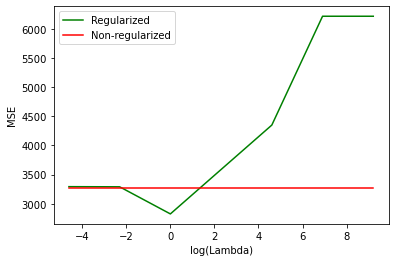

Min error:2827.1917808219177


In [109]:
y_pred_non_reg = predict(X_train, y_train, X_test, k=best_k, w=1, distance_metric=distance_metric)
benchmark = mean_squared_error(y_test, y_pred_non_reg)

errors = []
for i in lambdas:
    reg_coeff = regularization_coeffients(X_train, y_train, lambd=i)
    y_pred_reg = predict(X_train, y_train, X_test, k=best_k, w=reg_coeff, distance_metric=distance_metric)
    errors.append(mean_squared_error(y_test, y_pred_reg))
    
plot_results(lambdas, errors, benchmark, filename='manhattan.png')
min_error = min(errors)
print("Min error:"+str(min_error))

## Euclidean distance

In [110]:
distance_metric = 'minkowski'
p = 2

### Choosing K

In [111]:
errors = search_k(k_range, X_train, y_train, X_test, w=1, distance_metric=distance_metric)
min_error = min(errors.values())
best_k = min(errors, key=errors.get)

print("Min error:"+str(min_error))
print("Best K:"+str(best_k))

Min error:3278.8972602739727
Best K:13


### Checking lambda values vs benchmark

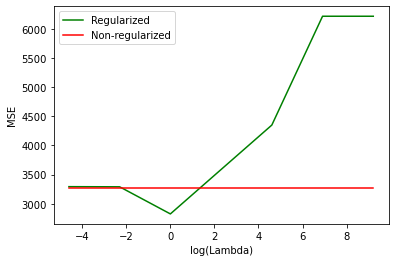

Min error:2827.1917808219177


In [112]:
y_pred_non_reg = predict(X_train, y_train, X_test, k=best_k, w=1, distance_metric=distance_metric)
benchmark = mean_squared_error(y_test, y_pred_non_reg)

errors = []
for i in lambdas:
    reg_coeff = regularization_coeffients(X_train, y_train, lambd=i)
    y_pred_reg = predict(X_train, y_train, X_test, k=best_k, w=reg_coeff, distance_metric=distance_metric)
    errors.append(mean_squared_error(y_test, y_pred_reg))
    
plot_results(lambdas, errors, benchmark, filename='euclidean.png')
min_error = min(errors)
print("Min error:"+str(min_error))

## Mahalanobis distance

In [113]:
distance_metric = 'mahalanobis'

### Choosing K

In [114]:
errors = search_k(k_range, X_train, y_train, X_test, w=1, distance_metric=distance_metric)
min_error = min(errors.values())
best_k = min(errors, key=errors.get)

print("Min error:"+str(min_error))
print("Best K:"+str(best_k))

Min error:3482.4109589041095
Best K:13


### Checking lambda values vs benchmark

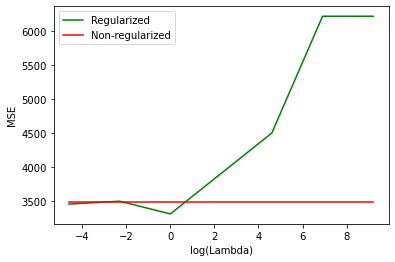

Min error:3314.0205479452056


In [115]:
y_pred_non_reg = predict(X_train, y_train, X_test, k=best_k, w=1, distance_metric=distance_metric)
benchmark = mean_squared_error(y_test, y_pred_non_reg)

errors = []
for i in lambdas:
    reg_coeff = regularization_coeffients(X_train, y_train, lambd=i)
    y_pred_reg = predict(X_train, y_train, X_test, k=best_k, w=reg_coeff, distance_metric=distance_metric)
    errors.append(mean_squared_error(y_test, y_pred_reg))
    
plot_results(lambdas, errors, benchmark, filename='mahalanobis.png')
min_error = min(errors)
print("Min error:"+str(min_error))